# Candidate class to analyse single pulses

In [1]:
from your.candidate import Candidate
from your.utils.plotter import plot_h5
import numpy as np
from scipy.signal import detrend
import os

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
%matplotlib inline

In [2]:
import pylab as plt
import logging

logger = logging.getLogger()
logger = logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -" " %(message)s",
)

## Loading the data
First, we make the candiate object with the relevant paramters of the candidate.

In [3]:
import tarfile
import tempfile
from urllib.request import urlretrieve

In [4]:
temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/askap_frb_180417.tgz"
url = "http://astro.phys.wvu.edu/files/askap_frb_180417.tgz"
urlretrieve(
    url, download_path,
)
frb_tar = tarfile.open(download_path)
frb_tar.extractall(path=os.path.dirname(download_path))
fil_file = temp_dir.name + "/28.fil"

## Candidate object

To create a candidate object you would need atleast:

* Source file (PSRFITS or filterbank)
* DM (pc/cc)
* Candiate arrival time (s)
* Pulse width (samples)

Here let's create the candidate object with some more details

In [5]:
cand = Candidate(
    fp=fil_file,
    dm=475.28400,
    tcand=2.0288800,
    width=2,
    label=-1,
    snr=16.8128,
    min_samp=256,
    device=0,
)

## Reading data
Get data, this will take data from the filterbank file, and can be accessed from `cand.data`:

In [6]:
cand.get_chunk()
print(cand.data, cand.data.shape, cand.dtype)

[[124 114 143 ... 145 118 159]
 [108 158 129 ... 122 142 158]
 [122 123 131 ... 119 142 129]
 ...
 [114 113 142 ... 120 141 160]
 [120 113 103 ... 146 107 136]
 [139 133 113 ... 146 141 160]] (991, 336) <class 'numpy.uint8'>


## Dedispersion

Here is our dispersed pulse (it is weak to see)

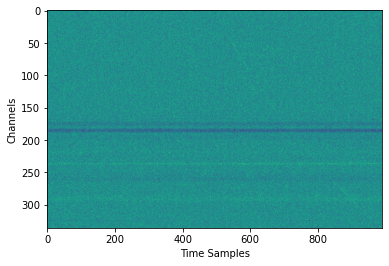

In [7]:
plt.imshow(cand.data.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

Now let's make the DM Time plot.

**Note:** This may take a while. 

In [8]:
cand.dmtime()

Using <class 'str'>:
/tmp/tmpapkzo46a/28.fil

The DM time data can be accessed using `cand.dmt`. Let's have a look: 

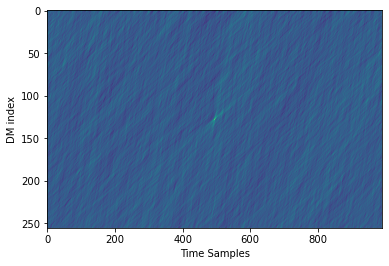

In [9]:
plt.imshow(cand.dmt, aspect="auto", interpolation=None)
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

We can see the bow-tie shape and the peak in the middle in the above plot. Now let's dedisperse the data!

In [10]:
cand.dedisperse()

Using <class 'str'>:
/tmp/tmpapkzo46a/28.fil

The dedispersed frequency-time can be obtained using `cand.dedispersed`

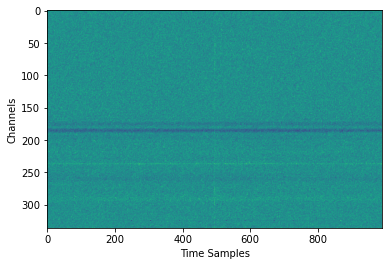

In [11]:
plt.imshow(cand.dedispersed.T, aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

The FRB is weakly visible in the middle of the plot. To see the FRB pulse profile let's plot the time series 

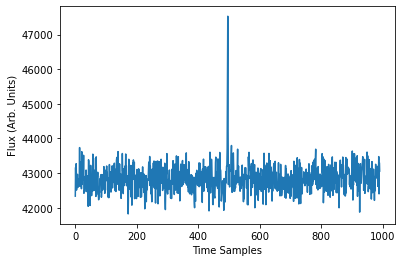

In [12]:
plt.plot(cand.dedispersed.T.sum(0))
plt.xlabel("Time Samples")
plt.ylabel("Flux (Arb. Units)")
plt.show()

## Detrending

[Detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) can be used to remove bandpass variations.

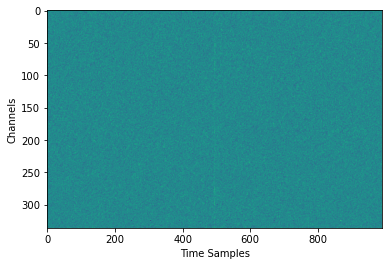

In [13]:
plt.imshow(detrend(cand.dedispersed.T), aspect="auto", interpolation=None)
plt.ylabel("Channels")
plt.xlabel("Time Samples")
plt.show()

We can have a look at the bandpass with and without [detrending](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html) .

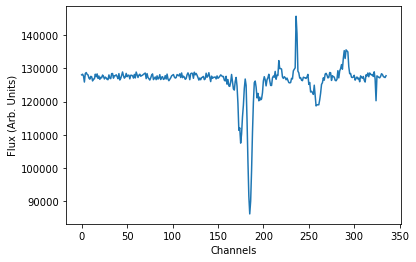

In [14]:
# Without detrend
plt.plot(cand.dedispersed.T.sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

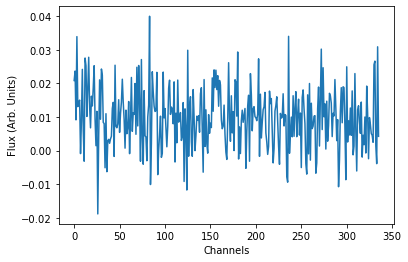

In [15]:
# With detrend
plt.plot(detrend(cand.dedispersed.T).sum(1))
plt.xlabel("Channels")
plt.ylabel("Flux (Arb. Units)")
plt.show()

## DM Optimization

Single pulse search pipelines lines often report approimate DMs. We can find the DM which maximizes our Signal to Noise Ratio (SNR) using the [`optimize_dm`](https://devanshkv.github.io/your/candidate/#optimize_dm) method. We assume that the DM vs -SNR curve is a convex function and use [`golden`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.golden.html) method to find the minima. The function returns optimal DM and SNR.

**Note** This is an experimental feature. 

In [16]:
cand.optimize_dm()
print(f"Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}")
print(f"Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}")

Heimdall reported dm: 475.284, Optimised DM: 474.7613272736851
Heimdall reported snr: 16.8128, SNR at Opt. DM: 14.077508926391602


## Saving the candidate

For now, let's enter `-1` as values for `dm_opt` and `snr_opt`

In [17]:
cand.dm_opt = -1
cand.snr_opt = -1

Each candiate gets a unique ID which can be accessed using `cand.id`

In [18]:
cand.id

'cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280'

Now let's save our candidate in an h5 file

In [19]:
fout = cand.save_h5()
print(fout)

2020-08-26 18:47:36,236 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


We will use [`plot_h5`](https://devanshkv.github.io/your/utils/plotter/#plot_h5) function to plot the candidate h5 we just generated.

2020-08-26 18:47:38,773 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

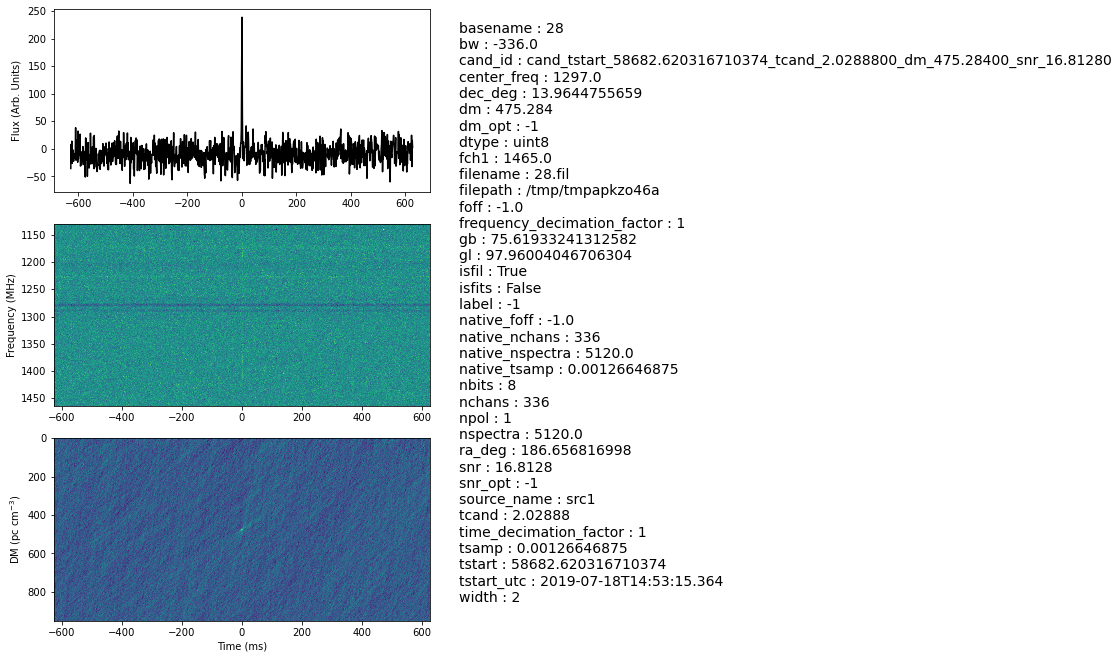

In [20]:
plot_h5(fout, detrend_ft=False, save=True)

We can also create publication quality plots right here using `publication=True` argument.

2020-08-26 18:47:44,989 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

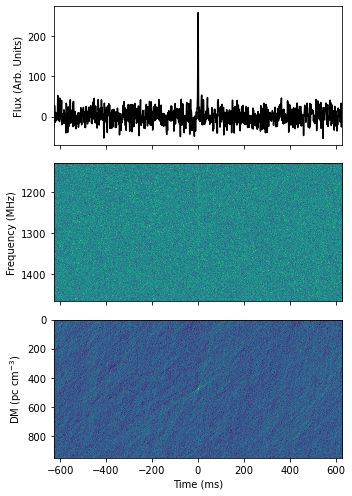

In [21]:
plot_h5(fout, detrend_ft=True, save=True, publication=True)

## Reshaping and Resizing

### Reshaping Freq-time and DM-time arrays

In [22]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [23]:
print(f"Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}")
print(f"Shape of DM-time data: {dmt_bkup.shape}")

Shape of dedispersed (frequency-time) data: (336, 991)
Shape of DM-time data: (256, 991)


In [24]:
time_size = 256
freq_size = 256

### Using resize in skimage.transform for reshaping

In [25]:
# resize dedispersed Frequency-time array along frequency axis
logging.info(f"Resizing time axis")
cand.resize(key="ft", size=time_size, axis=0, anti_aliasing=True)
logging.info(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

# resize dedispersed Frequency-time array along time axis
logging.info(f"Resizing frequency axis")
cand.resize(key="ft", size=freq_size, axis=1, anti_aliasing=True)
logging.info(
    f"Shape of dedispersed (frequency-time) data after resizing: {cand.dedispersed.T.shape}"
)

2020-08-26 18:47:50,157 - root - MainThread - INFO - Resizing time axis
2020-08-26 18:47:50,210 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (336, 256)
2020-08-26 18:47:50,215 - root - MainThread - INFO - Resizing frequency axis
2020-08-26 18:47:50,241 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after resizing: (256, 256)


In [26]:
# resize DM-time array along time axis
cand.resize(key="dmt", size=time_size, axis=1, anti_aliasing=True)
logging.info(f"Shape of DM-time data after resizing: {cand.dmt.shape}")

2020-08-26 18:47:50,300 - root - MainThread - INFO - Shape of DM-time data after resizing: (256, 256)


### Using decimate for reshaping

In [27]:
from candidate import crop

In [28]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [29]:
logging.info(f"Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}")

2020-08-26 18:47:50,422 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data: (336, 991)


In [30]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2

freq_decimation_factor = cand.dedispersed.shape[1] // freq_size
logging.info(f"Time decimation factor is {time_decimate_factor}")
logging.info(f"Frequency decimation factor is {freq_decimation_factor}")

2020-08-26 18:47:50,459 - root - MainThread - INFO - Time decimation factor is 1
2020-08-26 18:47:50,467 - root - MainThread - INFO - Frequency decimation factor is 1


Let's set the factors to something more interesting than 1

In [31]:
time_decimate_factor = 2
frequency_decimate_factor = 2

In [32]:
# Decimating time axis, and cropping to the final size
cand.decimate(
    key="ft", axis=0, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
logging.info(
    f"Shape of dedispersed (frequency-time) data after time decimation: {cand.dedispersed.T.shape}"
)

# Cropping the time axis to a required size
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)
logging.info(
    f"Shape of dedispersed (frequency-time) data after time decimation + crop: {cand.dedispersed.T.shape}"
)

# Decimating frequency axis
cand.decimate(
    key="ft", axis=1, pad=True, decimate_factor=frequency_decimate_factor, mode="median"
)
logging.info(
    f"Shape of dedispersed (frequency-time) data after decimation: {cand.dedispersed.T.shape}"
)

2020-08-26 18:47:50,513 - your.utils.misc - MainThread - INFO - padding along axis 0
2020-08-26 18:47:50,567 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation: (336, 496)
2020-08-26 18:47:50,570 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after time decimation + crop: (336, 256)
2020-08-26 18:47:50,574 - root - MainThread - INFO - Shape of dedispersed (frequency-time) data after decimation: (168, 256)


In [33]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size
logging.info(f"Original shape of DM-time data after time decimation: {cand.dmt.shape}")
cand.decimate(
    key="dmt", axis=1, pad=True, decimate_factor=time_decimate_factor, mode="median"
)
logging.info(f"Shape of DM-time data after time decimation: {cand.dmt.shape}")

crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)

logging.info(f"Shape of DM-time data after time decimation + crop: {cand.dmt.shape}")

2020-08-26 18:47:50,591 - root - MainThread - INFO - Original shape of DM-time data after time decimation: (256, 991)
2020-08-26 18:47:50,606 - your.utils.misc - MainThread - INFO - padding along axis 1
2020-08-26 18:47:50,639 - root - MainThread - INFO - Shape of DM-time data after time decimation: (256, 496)
2020-08-26 18:47:50,642 - root - MainThread - INFO - Shape of DM-time data after time decimation + crop: (256, 256)


Let's take a final look at the data. Decimation reduces the standard deviation of the data so the candidates should look more significant now. 

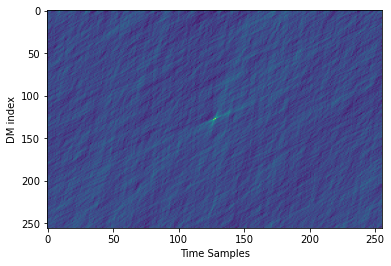

In [34]:
plt.imshow(cand.dmt, aspect="auto")
plt.ylabel("DM index")
plt.xlabel("Time Samples")
plt.show()

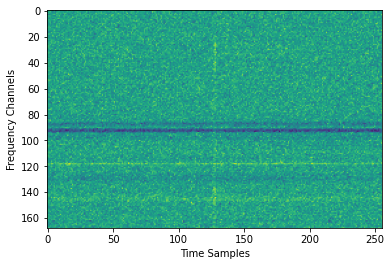

In [35]:
plt.imshow(cand.dedispersed.T, aspect="auto")
plt.ylabel("Frequency Channels")
plt.xlabel("Time Samples")
plt.show()

We can save this decimated data to h5 files using the same command as before

In [36]:
fout = cand.save_h5()
print(fout)

2020-08-26 18:47:52,085 - your.candidate - MainThread - INFO - Saving h5 file cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5.


cand_tstart_58682.620316710374_tcand_2.0288800_dm_475.28400_snr_16.81280.h5


2020-08-26 18:47:52,389 - root - MainThread - WARNING - Lengh of time axis is not 256. This data is probably not pre-processed.


<Figure size 432x288 with 0 Axes>

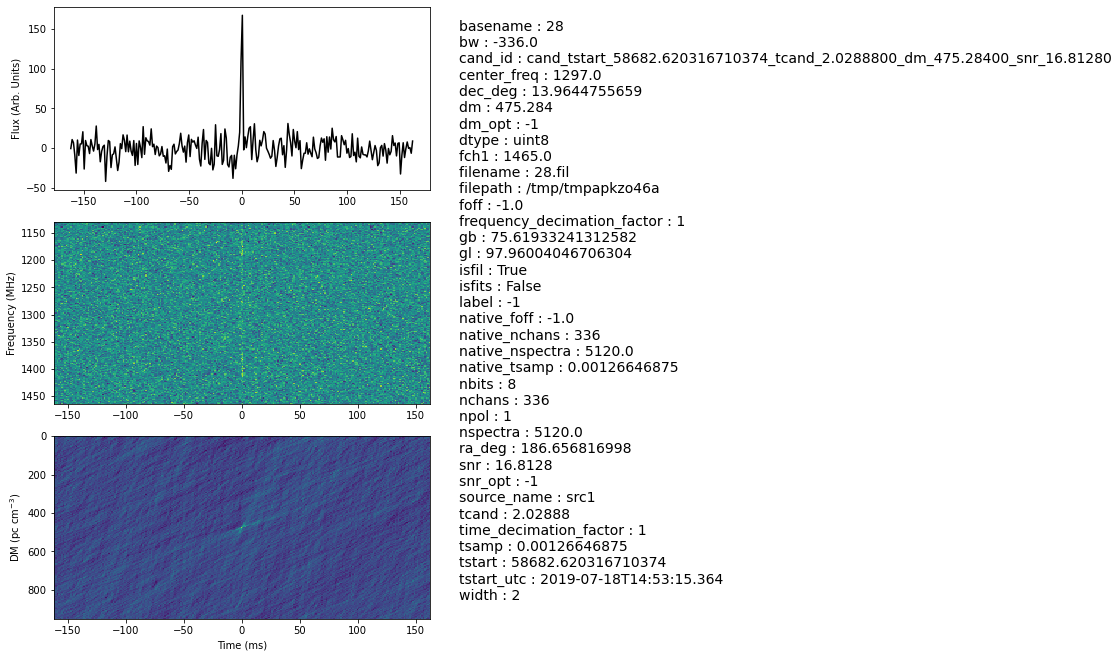

In [37]:
# Let's also detrend to remove the bandpass variations
plot_h5(fout, detrend_ft=True, save=True)